> Initial pre-processing include the extraction of information about target CpGs. The code is available in `script_helpers`. Master-script: `script_helpers/run_all.sh`

## Load packages

In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from matplotlib.patches import Rectangle

from scipy.stats import truncnorm, norm, pearsonr

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

## Define default parameters

In [2]:
plt.rcParams["figure.figsize"] = (4, 4)

DATA_FOLDER = 'data'
FIGURES_FOLDER = 'pics'

In [3]:
colors = ['#bebada', '#fb8072', '#80b1d3', 'black', '#d9d9d9']

## Modelling single-cell one site DNAm state

Matrix of initial states: $\mathbb{\Pi} = (p_{0}\quad p_{1})$

In [4]:
Pi_init = np.array([[1, 0]])
Pi_init

array([[1, 0]])

Matrix of initial transition probabilities: $\mathbb{P} = \begin{pmatrix} 1-p & p \\ q &1-q \end{pmatrix} $

In [5]:
p, q = 0.5 * 10 ** (-4), 0.5 * 10 ** (-4)

P_init = np.array([[1 - p, p], [q, 1 - q]])
P_init

array([[9.9995e-01, 5.0000e-05],
       [5.0000e-05, 9.9995e-01]])

Forward equation for Markov chain process (for inconditional probabilities):
$$ \mathbb{\Pi}^{(t)} = \mathbb{\Pi} \cdot \mathbb{P}^{(k)} = \mathbb{\Pi} \cdot \mathbb{P}^k $$

In [6]:
def roll_through_Pi_t(dnam_frac: float, 
                     p: float, 
                     q: float, 
                     num_states: int) -> list:
    
    P_init = np.array([[1 - p, p], [q, 1 - q]])
    Pi_init = np.array([[1 - dnam_frac, dnam_frac]])
    
    P_dnam = []
    P_t = None
    
    for _ in range(0, num_states):
        if P_t is None:
            P_t = P_init
        else:
            P_t = P_t @ P_init
        Pi_t = (Pi_init @ P_t)
        P_dnam.append(Pi_t[:, 1])
        
    return P_dnam

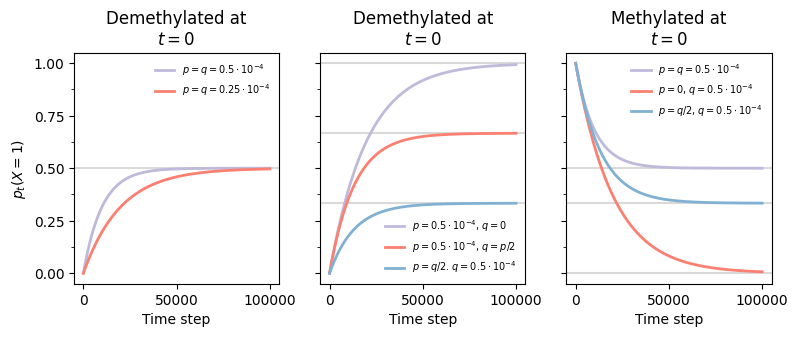

In [7]:
num_states = 100000

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3))

dnam_frac = 0
p = 0.5 * 10 ** (-4)
q = 0.5 * 10 ** (-4)

# steady state
axs[0].axhline(p/(q+p), c=colors[-1])
# plot sim
axs[0].plot(range(num_states), roll_through_Pi_t(dnam_frac, p, q, num_states), 
                         linewidth=2, c=colors[0], label='$p=q=0.5\cdot10^{-4}$')
axs[0].plot(range(num_states), roll_through_Pi_t(dnam_frac, p/2, q/2, num_states), 
                         linewidth=2, c=colors[1], label='$p=q=0.25\cdot10^{-4}$')

axs[0].set_ylabel('$p_t(X=1)$')
axs[0].set_title('Demethylated at\n$t=0$')
axs[0].legend(frameon=False, fontsize="7", loc='upper right')

# steady states
axs[1].axhline(p/(0*q+p), c=colors[-1])
axs[1].axhline(p/(2*(q+p/2)), c=colors[-1])
axs[1].axhline(p/(q/2+p), c=colors[-1])
# plot sim
axs[1].plot(range(num_states), roll_through_Pi_t(dnam_frac, p, 0, num_states), 
                         linewidth=2, c=colors[0], label='$p=0.5\cdot10^{-4}$, $q=0$')
axs[1].plot(range(num_states), roll_through_Pi_t(dnam_frac, p, p/2, num_states), 
                         linewidth=2, c=colors[1], label='$p=0.5\cdot10^{-4}$, $q=p/2$')
axs[1].plot(range(num_states), roll_through_Pi_t(dnam_frac, q/2, q, num_states), 
                         linewidth=2, c=colors[2], label='$p=q/2$. $q=0.5\cdot10^{-4}$')
axs[1].set_title('Demethylated at\n$t=0$')
axs[1].legend(frameon=False, fontsize="7", loc='lower right')

dnam_frac = 1
# steady states
axs[2].axhline(p/(q+p), c=colors[-1])
axs[2].axhline(0 * p/(q+p*0), c=colors[-1])
axs[2].axhline(p/(2*(q+p/2)), c=colors[-1])
# plot sim
axs[2].plot(range(num_states), roll_through_Pi_t(dnam_frac, p, q, num_states), 
                         linewidth=2, c=colors[0], label='$p=q=0.5\cdot10^{-4}$')
axs[2].plot(range(num_states), roll_through_Pi_t(dnam_frac, 0, q, num_states), 
                         linewidth=2, c=colors[1], label='$p=0$, $q=0.5\cdot10^{-4}$')
axs[2].plot(range(num_states), roll_through_Pi_t(dnam_frac, q/2, q, num_states), 
                         linewidth=2, c=colors[2], label='$p=q/2$, $q=0.5\cdot10^{-4}$')
axs[2].set_title('Methylated at\n$t=0$')
axs[2].legend(frameon=False, fontsize="7", loc='upper right')

for ax in axs:
    ax.set_xlabel('Time step')
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.set_yticks(np.arange(0, 1.01, 0.125), minor=True)

plt.savefig(os.path.join(FIGURES_FOLDER, '1_single_cell_dnam.svg'), 
            dpi=300, bbox_inches='tight')

## Constructing stochastic model for cell population

### Procedure description

When we switch from the one-cell to cell population, we need to generalize our model. 
To do so, I will provide several definitions, which authors used in the paper.

First, instead of one CpG site, I will consider several (353) that belong to Horvath's clock. For each of CpG $c$, I define independent procedure of estimaion of methylation change.  
Second, instead of one boolinan variable, $X \in \{1, 0\}$ defining methylation status in single cell, I operate with the fraction of methylated sites in particular position, named DNAm.

Thus, taking into account the described diffences, a simulation of the stochastic  will consists of the following steps.

#### 1. Initial methylation status distribution.  
The initial methylation status corresponds to fraction of methylated sites in particular position at the beginning of observation (DNAm). Following the paper, I define the initial methylation status for each CpG $c$ as an average DNAm for young samples (avgDNAm(Young)). 

#### 2. Definition of probability of transition  
I model the change of methylation status at CpG $c$ occuring with probability $p_c$:

$$p_c = 1 - e^{-\gamma |\text{EffSize}_c|} $$
where $\gamma$ is global probability of a DNAm change (discussed below), and $\text{EffSize}_{c}$ is an effect size, which defined as difference in methylation fraction DNAm for betweem old and young. Mathematically, for each CpG $c$ in a CpG set:
$$ \text{EffSize}_c = \text{avgDNAm(Old)} - \text{avgDNAm(Young)}$$

#### 3. Definition of transition
3.1. Since we switched to cell population, we need to define how the transition will happen. Since we have a population, the change in methylation status of CpG $c$ will change of DNAm from $\beta _c ^{(t)}$ at time step $t$ to $\beta _c ^{(t+1)}$. The DNAm values are defined as $\beta_c$ since they are beta-distributed (shown below).  
3.2. The size of DNAm change is defined as a random deviation $r_{c}$ from truncated normal distribution $r_{c} \sim \mathcal{N}_{+}(0, \sigma)$. Sign of change is same as siogn of effect size: $\text{sign}(\text{EffSize}_{c})$.  
3.3. Change in DNAm. Since the DNAms $\beta _c ^{(t)}$ are beta-distributed and the $r$ belongs to truncated normal distribution I first transform the DNAm to normal distribution, change the value, and then convert it back to the beta-values. Thus,
$$\beta _c ^{(t)} \quad \rightarrow \quad x_c^{(t)} = iF(\beta_{c}^{(t)}),$$ 
where $iF$ is inverse of the normal cumulative distribution function. Next,
$$ x_c^{(t+1)} = x_c^{(t)} + \text{sign}( \text{EffSize}_{c} ) \cdot r_{c}, \  r_{c} \sim \mathcal{N}_{+}(0, \sigma)$$
and, finally,
$$\beta _c ^{(t+1)} = F(x_{c}^{(t+1)})$$ 

### Read info about Horvath CpGs 

In this project, I aimed to counstruct StocH, stochastic Horvath clocks. Thus, I select 353 Horvath clock CpGs.  
[Paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC4015143/#sec45)

In [8]:
cpg_ids = pd.read_pickle(os.path.join(DATA_FOLDER, 'horvaths.pkl'))
cpg_ids.head()

1    cg00075967
2    cg00374717
3    cg00864867
4    cg00945507
5    cg01027739
Name: CpGmarker, dtype: object

### Load Multi-Ethnic Study of Atherosclerosis (MESA) sorted monocytes dataset

To specify the model, I will use the MESA dataset.  
I select the DNAm for Horvath 353 CpGs of monocyte samples from the MESA study (See preprocessing at `script_helpers/process_source_data.py`).

Link:  
[GSE56046](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE56046])



In [9]:
dataset = 'CD14'
dnam_fracs_path = os.path.join(DATA_FOLDER, f'{dataset}_DNAm_frac.pkl')
dnam_age_path = os.path.join(DATA_FOLDER, f'{dataset}_sample.pkl')

dnam_fracs = pd.read_pickle(dnam_fracs_path)
sample_age = pd.read_pickle(dnam_age_path).rename(columns={'Sample_title': 'sample'}).set_index('sample')

dnam_fracs_T = dnam_fracs.T
dnam_df = dnam_fracs_T.join(sample_age)
dnam_df.head()

,cg00075967,cg00374717,cg00864867,cg00945507,cg01027739,cg01353448,cg01584473,cg01644850,cg01656216,cg01873645,...,cg26394940,cg26456957,cg26614073,cg26723847,cg26824091,cg27015931,cg27016307,cg27202708,cg27544190,age
sample,,,,,,,,,,,,,,,,,,,,,
100001,0.797041,0.907275,0.092022,0.578775,0.123283,0.565195,0.826076,0.080117,0.832883,0.076878,...,0.080064,0.083260,0.397128,0.120678,0.107899,0.186492,0.478638,0.452308,0.153405,59
100002,0.844585,0.928587,0.097439,0.567009,0.141442,0.688289,0.852662,0.064048,0.822792,0.079095,...,0.132681,0.086489,0.592902,0.106581,0.113552,0.166717,0.623318,0.471839,0.147084,63
100003,0.879970,0.933025,0.102262,0.717821,0.203232,0.718010,0.833317,0.061020,0.824854,0.079077,...,0.059213,0.077034,0.506607,0.120923,0.148456,0.181006,0.631689,0.671913,0.132098,71
100004,0.879591,0.906788,0.086495,0.273598,0.135780,0.542587,0.828943,0.078403,0.779541,0.060600,...,0.062042,0.084634,0.411019,0.092335,0.090946,0.163280,0.520686,0.146486,0.103398,72
100005,0.834376,0.928605,0.086850,0.392796,0.111547,0.609192,0.813379,0.077619,0.806230,0.086617,...,0.067626,0.088622,0.469478,0.154938,0.122932,0.196068,0.453328,0.364385,0.152168,48


### Estimate Effect Sizes

Estimated effect size will be passed it into a model simulation.

**Plot age distribution**

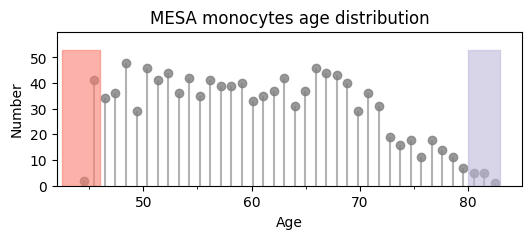

In [10]:
fig, ax = plt.subplots(figsize=(6, 2))

h, x = np.histogram(dnam_df['age'], bins=40)
x_=(x[:-1]+x[1:])/2
mask = (h == 0)

ax.vlines(x_[~mask], ymin=0, ymax=h[~mask], color='grey', alpha=0.6, zorder=0)
ax.scatter(x_[~mask], h[~mask], color='grey', alpha=0.8)


ax.add_patch(Rectangle(xy=(42.5, 0), width=3.5, height=max(h)+5, color=colors[1], alpha=0.6))
ax.add_patch(Rectangle(xy=(80, 0), width=3, height=max(h)+5, color=colors[0], alpha=0.6))

ax.set_xticks(np.arange(50, 86, 10))
ax.set_xticks(np.arange(45, 85, 5), minor=True)
ax.set_yticks(np.arange(0, 51, 10))
ax.set_xlim(42, 85)
ax.set_ylim(0, 60)
ax.set_xlabel('Age')
ax.set_ylabel('Number')
ax.set_title('MESA monocytes age distribution')

plt.savefig(os.path.join(FIGURES_FOLDER, '2_mesa_mono_age_distr.svg'), 
            dpi=300, bbox_inches='tight')

**Select oldest and youngest**

In [11]:
young_dnam_df = dnam_df.query('age < 46')
old_dnam_df = dnam_df.query('age > 80')

In [12]:
# calculate average DNAm fractions
young_dnam_avg = young_dnam_df.mean()[:-1]
old_dnam_avg = old_dnam_df.mean()[:-1]

# save the average DNAm fraction of youngest as the starting DNAm fraction 
starnting_dnam_frac = young_dnam_avg.copy()

# calculate an effect size as a difference between young and old
effect_sizes = old_dnam_avg - young_dnam_avg

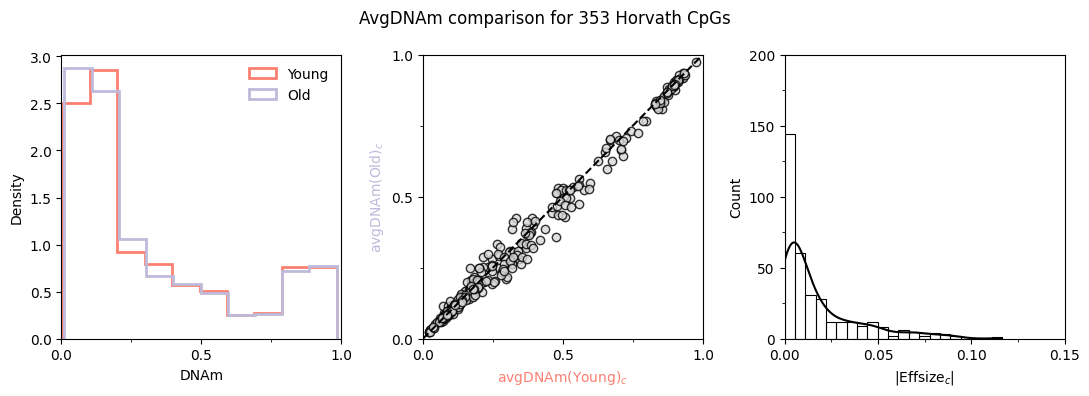

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(11, 4))


ax[0].hist(young_dnam_df.to_numpy()[:, :-1].flatten(), histtype="step", density=True,
           linewidth=2, edgecolor=colors[1], label='Young')
ax[0].hist(old_dnam_df.to_numpy()[:, :-1].flatten(), histtype="step", density=True, 
           linewidth=2, edgecolor=colors[0], label='Old')
ax[0].set_xlabel('DNAm')
ax[0].set_ylabel('Density')
ax[0].set_xticks(np.arange(0, 1.01, 0.5))
ax[0].set_xticks(np.arange(0, 1.01, 0.25), minor=True)
ax[0].set_xlim(0, 1)
ax[0].legend(frameon=False)


ax[1].scatter(young_dnam_avg, old_dnam_avg, color=colors[-1], edgecolors=colors[-2], alpha=0.8)
ax[1].plot([0, 1], [0, 1], ls="--", color=colors[-2])
ax[1].set_xlabel('avgDNAm(Young)$_c$', color=colors[1])
ax[1].set_ylabel('avgDNAm(Old)$_c$', color=colors[0])
ax[1].set_xticks(np.arange(0, 1.01, 0.5))
ax[1].set_xticks(np.arange(0, 1.01, 0.25), minor=True)
ax[1].set_yticks(np.arange(0, 1.01, 0.5))
ax[1].set_yticks(np.arange(0, 1.01, 0.25), minor=True)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)


sns.histplot(effect_sizes.abs(), color=colors[-2],
             fill=False,
             kde=True,
             ax=ax[2])
ax[2].set_xlabel('|Effsize$_c$|')
ax[2].set_xticks(np.arange(0, 0.21, 0.05))
ax[2].set_xticks(np.arange(0, 0.21, 0.025), minor=True)
ax[2].set_yticks(np.arange(0, 201, 50))
ax[2].set_yticks(np.arange(0, 201, 25), minor=True)
ax[2].set_xlim(0, 0.15)
ax[2].set_ylim(0, 200)

plt.suptitle('AvgDNAm comparison for 353 Horvath CpGs')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_FOLDER, '2_2_dnam_characteristics.svg'),
            dpi=300, bbox_inches='tight')

## Optimize parameters of stochastic model

In the procedure described above, there are two parameters need to be optimized: global methylation change rate $\gamma$, and $\sigma$, defining the methylation magnitude of of methylation change.
This section is dedicated to optimization of the parameters such that the obtained stochastic clocks would have the DNAm at the end of simulation (e.g. for Old samples) similar to ovserved DNAm (for observed Old samples).

In [14]:
"""
here and after the np.vectorize functions are used
the way of this code operation is given in this cell
"""


@np.vectorize
def test_mul(x, y):
    return x * y


a = np.array([0, 1, 2, 3])
b = np.array([4, 5])

"""
resulting matrix consists of the following elements:
a[0] * b[0]     a[1] * b[0]    a[2] * b[0], ...
a[1] * b[1]     a[1] * b[1]    a[2] * b[0], ...
"""
test_mul(a, b[:, np.newaxis])

array([[ 0,  4,  8, 12],
       [ 0,  5, 10, 15]])

Definition of emission of the state change:

In [15]:
@np.vectorize
def p_c(effsize, gamma):
    """
    calculate the probability of methylation state for particular effect size of CpG (effsize_c) and 
    global probability of a DNAm change (gamma)
    """
    return 1 - np.exp(-gamma * np.abs(effsize))


@np.vectorize
def change_state_status(effsize_c, gamma):
    """
    emits the state of methylation, based on defined effect size of CpG (effsize_c) and 
    global probability of a DNAm change (gamma)
    """
    p = p_c(effsize_c, gamma)
    return np.random.choice([0, 1], 1, True, [1-p, p])[0]


# an example
gamma = np.array([1, 2, 3, 6])
effsize_c = np.array([0.05, 0.08, -0.06])

change_state_status(effsize_c, gamma[:, np.newaxis])

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 1]])

Define the logic of the DNAm change:

In [16]:
def r_c(sigma):
    return truncnorm.rvs(a=0, b=np.inf, loc=0, scale=sigma)


def x_c(beta_c):
    return norm.ppf(beta_c)


def x_c_next(x_c_, sigma, effsize_c):
    return x_c_ + np.sign(effsize_c) * r_c(sigma)

@np.vectorize
def beta_c_next(effsize_c, gamma, beta_c, sigma):
    ch_st = change_state_status(effsize_c, gamma)
    if ch_st == 1:
        x_c_val = x_c(beta_c)
        x_c_next_val = x_c_next(x_c_val, sigma, effsize_c)
        return norm.cdf(x_c_next_val)
    else:
        return beta_c


Try to apply the procedure to fixed $\gamma$ and $\sigma$ for see the dynamics of change of DNAm.

In [17]:
n_steps = 37 * 35
dnams = [[] for _ in range(3)]
for i in range(3):
    # first step depends on avgDNAm(young)
    dnams[i].append(beta_c_next(effsize_c=effect_sizes, gamma=9.25, 
                                beta_c=young_dnam_avg, sigma=0.0005))

    # next steps depend on previous states
    for t in range(n_steps - 1):
        dnams[i].append(beta_c_next(effsize_c=effect_sizes, gamma=9.25, 
                                    beta_c=dnams[i][-1], sigma=0.0005))

Let's look at the dynamics of methylarion for several CpGs.

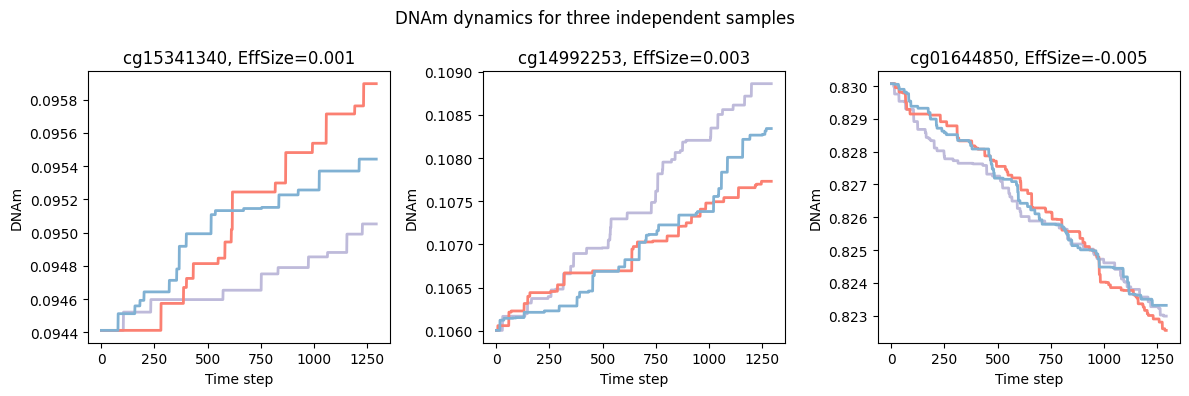

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
rs = [104, 103, 8]
for i in range(3):
    r = rs[i]
    for j in range(3):
        ax[i].plot(np.arange(n_steps), np.array(dnams)[j, :, r], linewidth=2, color=colors[j])
    ax[i].set_title(f'{cpg_ids.loc[r]}, EffSize={round(effect_sizes.iloc[r], 3)}')
    ax[i].set_xlabel('Time step')
    ax[i].set_ylabel('DNAm')

plt.suptitle('DNAm dynamics for three independent samples')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_FOLDER, '3_simulation_random_chains.svg'), 
            dpi=300, bbox_inches='tight')

First, the changes in DNAm are monotonous, as expected. Second, one can see that the increase of $\text{EffSize}$ increases chance of DNAm change, while its' sign defines direction (increase or decrease) of DNAm change.

In [19]:
# evaluation of MAE for the 
last_dnam_step = dnams[-1][-1]
mean_absolute_error(effect_sizes, last_dnam_step - young_dnam_avg)

0.005031753852139988

In [20]:
dnam_step_not_optimal = beta_c_next(effsize_c=effect_sizes, gamma=3, 
                                    beta_c=young_dnam_avg, sigma=0.0001)
for _ in range(n_steps):
    dnam_step_not_optimal = beta_c_next(effsize_c=effect_sizes, gamma=3, 
                                        beta_c=dnam_step_not_optimal, sigma=0.0001)

In [21]:
mean_absolute_error(effect_sizes, dnam_step_not_optimal - young_dnam_avg)

0.015842255434039318

> Grid search of MAE-optimal gamma and sigma can be found at `script_helpers/search_optimal_parameters.py`.

The resulting table of obtained MAEs:

In [22]:
scores = pd.read_csv(os.path.join(DATA_FOLDER, 'mae_res.tsv'), 
                    sep='\t', 
                    names=['gamma', 'sigma', 'MAE'])
scores.head()

,gamma,sigma,MAE
0,1.0,0.00010,0.016884
1,1.0,0.00025,0.016055
2,1.0,0.00040,0.015226
3,1.0,0.00055,0.014397
4,1.0,0.00070,0.013568


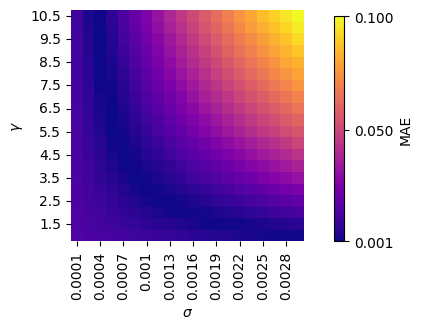

In [23]:
scores_tab = scores.pivot(index='gamma', columns='sigma', values='MAE').sort_values('gamma', ascending=False)

cnorm = Normalize(0.001, 0.1)

fig, ax = plt.subplots(figsize=(3,3))

sns.heatmap(scores_tab, cmap='plasma', cbar=None, ax=ax)

ax.set_ylabel('$\gamma$')
ax.set_xlabel('$\sigma$')

cbar_x, cbar_y = 1, .16
cbar_len = 0.035
cbar_heigth = 0.75
cax = plt.axes((cbar_x, cbar_y-0.05, cbar_len, cbar_heigth))
plt.colorbar(cm.ScalarMappable(cnorm, 'plasma'), cax=cax, orientation='vertical',
             ticks=[0.001, 0.05, 0.1],
             label='MAE', location='right'
            )
plt.savefig(os.path.join(FIGURES_FOLDER, '4_optimizing_parameters.svg'),
            dpi=300, bbox_inches='tight')


In [24]:
opt_scores = scores.iloc[scores['MAE'].idxmin()]
gamma, sigma, mae = opt_scores
gamma, sigma, mae

(9.0, 0.0004, 0.0029926942264683)

Thus, I found optimal parameters. This results differ from the optimal parameters from the paper, because I ran only one simulation for each pair of the parameter due to lack of time and computational resources.

## Construction of the stochastic Horvath clocks (StocH)

### Simulate an artificial cohorts of samples

For each time step (or, age value), we now can now simulate the DNAm values, using the optimized $\sigma$ and $\gamma$ parameters, similarly to the procedure described at previous section. For initian DNAm values (relative age 0, or age 45), I used the same average DNAm level for young samples.

Following the paper, I simulated three artificial cohorts of DNAm samples: train, model selection and test sets. Each cohort consists of five samples per age value: from 45 to 83 (195 samples in total for each cohort).  
For the samples of year 45 I used the random number of time steps less than 35 (number of stem cells divsions per year) to has some variety in DNAm values for this age.
For each age, the DNAm were simulated from the same DNAm values independently, reflecting the stochastic process in each individual sample.

> Code for cohort simulations can be found at `script_helpers/simulate_artificial_cohorts.py`.

### Train a linear regression with combined L1 and L2 priors as regularizer (ElasticNet).



In [25]:
simulated_train_df = pd.read_pickle(os.path.join(DATA_FOLDER, 'simulated_cohort_train.pkl'))
simulated_train_df.columns = dnam_df.columns
simulated_train_df['age'] = (simulated_train_df['age'] + 45).astype(int)
simulated_train_df.head()

,cg00075967,cg00374717,cg00864867,cg00945507,cg01027739,cg01353448,cg01584473,cg01644850,cg01656216,cg01873645,...,cg26394940,cg26456957,cg26614073,cg26723847,cg26824091,cg27015931,cg27016307,cg27202708,cg27544190,age
0,0.851499,0.919924,0.085719,0.489711,0.138236,0.650987,0.832590,0.071561,0.830078,0.088004,...,0.103511,0.085216,0.496120,0.131812,0.115442,0.178872,0.528839,0.393138,0.139849,45
1,0.851446,0.919924,0.085650,0.489348,0.138337,0.651197,0.832474,0.071551,0.830021,0.088009,...,0.103528,0.085216,0.494503,0.131778,0.115459,0.178797,0.527030,0.391212,0.139600,46
2,0.850629,0.919836,0.085650,0.490287,0.138337,0.651375,0.832352,0.071730,0.829789,0.087963,...,0.103503,0.085216,0.493369,0.131619,0.115459,0.178797,0.524401,0.389081,0.139192,47
3,0.850139,0.919836,0.085726,0.491478,0.138436,0.651612,0.831892,0.071822,0.829588,0.087908,...,0.103420,0.085216,0.491065,0.131619,0.115459,0.178797,0.521852,0.386564,0.139068,48
4,0.849129,0.919736,0.085821,0.491816,0.138436,0.652360,0.831369,0.071878,0.829532,0.087908,...,0.103319,0.085141,0.488882,0.131188,0.115459,0.178797,0.520156,0.385089,0.138810,49


Same for test and validation.

In [26]:
# test
simulated_test_df = pd.read_pickle(os.path.join(DATA_FOLDER, 'simulated_cohort_test.pkl'))
simulated_test_df.columns = dnam_df.columns
simulated_test_df['age'] = (simulated_test_df['age'] + 45).astype(int)

#validation
simulated_validation_df = pd.read_pickle(os.path.join(DATA_FOLDER, 'simulated_cohort_validation.pkl'))
simulated_validation_df.columns = dnam_df.columns
simulated_validation_df['age'] = (simulated_validation_df['age'] + 45).astype(int)

#### Apply the standard scaling to the data.

In [27]:
X_train = simulated_train_df.iloc[:, :-1]
y_train = simulated_train_df.iloc[:, -1]

X_test = simulated_test_df.iloc[:, :-1]
y_test = simulated_test_df.iloc[:, -1]

X_validation = simulated_validation_df.iloc[:, :-1]
y_validation = simulated_validation_df.iloc[:, -1]

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_validation = scaler.fit_transform(X_validation)

#### Find optimal regularization parameter ($\lambda$ in the paper, penalty).

In [28]:
l1 = 0.5
scores = []
models = []
for alpha in np.arange(0, 1.00001, 0.001):
    
    elm = ElasticNet(alpha = alpha, l1_ratio=0.5, max_iter=3000, tol=1e-2)
    # train on train
    elm.fit(X_train, y_train)
    # predict for test
    y_pred = elm.predict(X_test)
    # calculate rmse for test
    rmse = mean_squared_error(y_test, y_pred)
    # save scores
    scores.append([alpha, rmse])
    models.append(elm)

/home/niagara/Storage/IBG/O_Kotovskaya/.conda/envs/cba_fin_proj/lib/python3.11/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/niagara/Storage/IBG/O_Kotovskaya/.conda/envs/cba_fin_proj/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


#### Check score on validation dataset

In [29]:
scores = np.array(scores)
min_alpha = scores[:, 0][scores[:, 1].argmin()]
# use the obtained model for best score to predict age on validation dataset
stocH = models[scores[:, 1].argmin()]

y_val_pred = stocH.predict(X_validation)

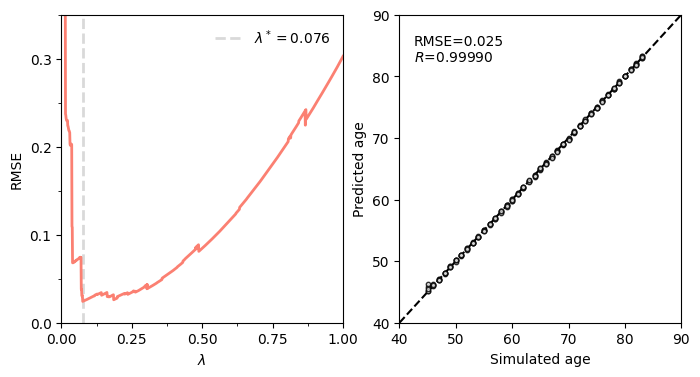

In [30]:

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(scores[:, 0], scores[:, 1], linewidth=2, color=colors[1])
ax[0].axvline(min_alpha, zorder=0, color=colors[-1],  
            linewidth=2, linestyle='dashed', 
            label=f'$\lambda^*=${min_alpha}')
ax[0].set_xlabel('$\lambda$')
ax[0].set_ylabel('RMSE')
ax[0].set_xticks(np.arange(0,1.01, 0.25))
ax[0].set_xticks(np.arange(0,1.01, 0.125), minor=True)
ax[0].set_yticks(np.arange(0,1.01, 0.1))
ax[0].set_yticks(np.arange(0,1.01, 0.05), minor=True)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0,0.35)
ax[0].legend(frameon=False)

ax[1].plot([40, 90], [40, 90], ls="--", color=colors[-2], zorder=0)
ax[1].scatter(y_validation, y_val_pred,  color=colors[-1], edgecolors=colors[-2], s=10, alpha=0.8)
ax[1].set_xlabel('Simulated age')
ax[1].set_ylabel('Predicted age')
ax[1].text(x= 0.05, y=0.85, s=f'$R$={(pearsonr(y_validation, y_val_pred)[0]):.5f}', 
           transform=ax[1].transAxes)
ax[1].text(x= 0.05, y=0.9, s=f'RMSE={(mean_squared_error(y_validation, y_val_pred)):.3f}', 
           transform=ax[1].transAxes)
ax[1].set_xticks(np.arange(40, 91, 10))
ax[1].set_yticks(np.arange(40, 91, 10))
ax[1].set_xlim(40, 90)
ax[1].set_ylim(40, 90)

plt.savefig(os.path.join(FIGURES_FOLDER, '5_optimizing_lambda.svg'), dpi=300, bbox_inches='tight')


Finally, I got StocH.

In [31]:
# save the best model
with open(os.path.join(DATA_FOLDER, 'stocH.pkl'), 'wb') as f:
    pickle.dump(stocH, f)

## Prediction of age in MESA dataset using StocH

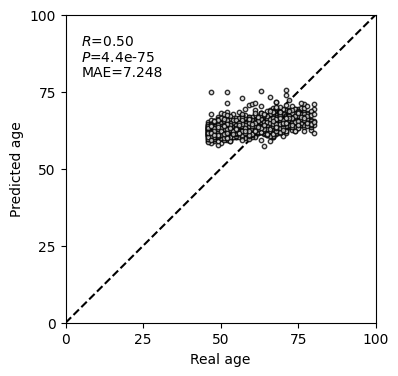

In [32]:
# define dataset
mesa_mono = dnam_df.query('46 <= age <= 80')
mesa_mono_X = mesa_mono.iloc[:, :-1]
mesa_mono_y = mesa_mono.iloc[:, -1]

# scale X
scaler_real_dat = StandardScaler()
mesa_mono_X_transformed = scaler_real_dat.fit_transform(mesa_mono_X)

# # predict age
mesa_mono_y_pred = stocH.predict(mesa_mono_X_transformed)

mesa_mono_mae = mean_absolute_error(mesa_mono_y, mesa_mono_y_pred)
mesa_mono_r = pearsonr(mesa_mono_y, mesa_mono_y_pred)

fig, ax = plt.subplots()
ax.plot([0, 100], [0, 100], ls="--", color=colors[-2], zorder=0)
ax.scatter(mesa_mono_y, mesa_mono_y_pred,  color=colors[-1], 
           edgecolors=colors[-2], s=10, alpha=0.8)
ax.set_xlabel('Real age')
ax.set_ylabel('Predicted age')
ax.text(x= 0.05, y=0.8, s=f'MAE={mesa_mono_mae:.3f}', transform=ax.transAxes)
ax.text(x= 0.05, y=0.9, s=f'$R$={mesa_mono_r[0]:.2f}', transform=ax.transAxes)
ax.text(x= 0.05, y=0.85, s=f'$P$={mesa_mono_r[1]:.1e}', transform=ax.transAxes)
ax.set_xticks(np.arange(0, 101, 25))
ax.set_yticks(np.arange(0, 101, 25))
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.savefig(os.path.join(FIGURES_FOLDER, '6_predicting_age_only_stocH.svg'), dpi=300, bbox_inches='tight')

## Quantification of stochastic component of epigenetic aging

### Init Horvath clocks

Since it's not mentioned, how the Horvath clocks were trained in the paper. One can use the same dataset for training and test with cross-validation, without excluding validation subset from training data, which is not good approach. In the paper, the number of samples used to prediction of age is similar to the whole dataset size (1148, thus, samples in range of 46 to 80). This, it's unclear, whether some validation used or not.
The following code can be used to fit Horvath's clocks:
```python
horvath = ElasticNetCV(l1_ratio=0.5, alphas=np.arange(0, 1.00001, 0.001))
horvath.fit(X, y)
y_pred = horvath.predict(X)
```

Another option is to use weights and parameters from the Horvath's initial paper. It should be mentioned that the Horvath's datasets did not include the MESA dataset, so basically I do not expect data leakage.



In [33]:
# read data
horvaths_weights = pd.read_csv('source_data/horvath_353_cpgs_s3.csv', skiprows=2).iloc[:, :2]
# read interest value and weights
intercept = horvaths_weights.iloc[0, 1]
horvaths_weights = horvaths_weights.iloc[1:].set_index('CpGmarker')
horvaths_weights = horvaths_weights.T[dnam_fracs_T.columns].to_numpy().flatten()

alpha_horvath = 0.0226  # from methods section
hc = ElasticNet(l1_ratio=0.5, alpha=alpha_horvath)
hc.coef_ = horvaths_weights
hc.intercept_ = intercept

mesa_mono_f_pred_h = hc.predict(mesa_mono_X)  # weights in paper are for beta values

# convert F(age) into age, for agult age equal to 20
adult_age = 20
mesa_mono_y_pred_h = mesa_mono_f_pred_h * (adult_age + 1) + adult_age
mesa_mono_mae_h = mean_absolute_error(mesa_mono_y, mesa_mono_y_pred_h)
mesa_mono_r_h = pearsonr(mesa_mono_y, mesa_mono_y_pred_h)

/home/niagara/Storage/IBG/O_Kotovskaya/.conda/envs/cba_fin_proj/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


### Comparing prediction of StocH and Horvath's clocks for monocytes dataset

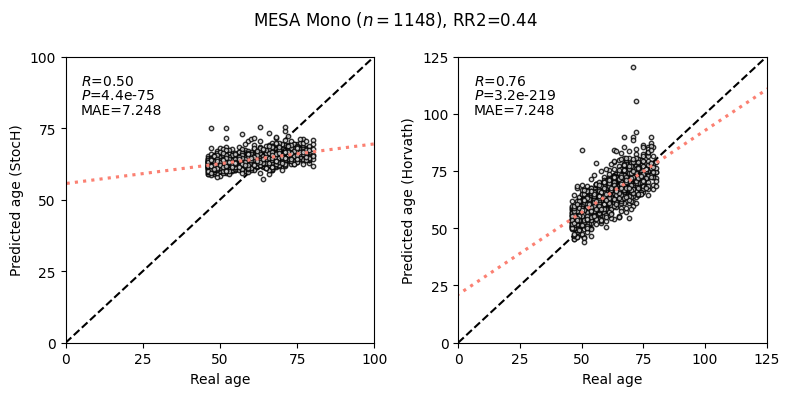

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

line_kws = {'color': colors[1], 
            'zorder': 2, 
            'linestyle': ':'}

scatter_kws = {'color': colors[-1], 
               'alpha': 0.8, 
               's': 10,
               'edgecolors': colors[-2]}

rr2 = (mesa_mono_r[0] ** 2 ) / (mesa_mono_r_h[0] ** 2)

ax[0].plot([0, 100], [0, 100], ls="--", color=colors[-2], zorder=0)
sns.regplot(x=mesa_mono_y, y=mesa_mono_y_pred, 
            truncate=False, ci=None,
            line_kws=line_kws,
            scatter_kws=scatter_kws,
            ax=ax[0]
            )
ax[0].set_xlabel('Real age')
ax[0].set_ylabel('Predicted age (StocH)')
ax[0].text(x= 0.05, y=0.8, s=f'MAE={mesa_mono_mae:.3f}',
           transform=ax[0].transAxes)
ax[0].text(x= 0.05, y=0.9, s=f'$R$={mesa_mono_r[0]:.2f}',
           transform=ax[0].transAxes)
ax[0].text(x= 0.05, y=0.85, s=f'$P$={mesa_mono_r[1]:.1e}',
           transform=ax[0].transAxes)
ax[0].set_xticks(np.arange(0, 101, 25))
ax[0].set_yticks(np.arange(0, 101, 25))
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 100)

ax[1].plot([0, 125], [0, 125], ls="--", color=colors[-2], zorder=0)
sns.regplot(x=mesa_mono_y, y=mesa_mono_y_pred_h, 
            truncate=False, ci=None,
            line_kws=line_kws,
            scatter_kws=scatter_kws,
            ax=ax[1]
            )
ax[1].set_xlabel('Real age')
ax[1].set_ylabel('Predicted age (Horvath)')
ax[1].text(x= 0.05, y=0.8, s=f'MAE={mesa_mono_mae:.3f}',
           transform=ax[1].transAxes)
ax[1].text(x= 0.05, y=0.9, s=f'$R$={mesa_mono_r_h[0]:.2f}',
           transform=ax[1].transAxes)
ax[1].text(x= 0.05, y=0.85, s=f'$P$={mesa_mono_r_h[1]:.1e}', 
           transform=ax[1].transAxes)
ax[1].set_xticks(np.arange(0, 131, 25))
ax[1].set_yticks(np.arange(0, 131, 25))
ax[1].set_xlim(0, 125)
ax[1].set_ylim(0, 125)

plt.suptitle(f'MESA Mono ($n=1148$), RR2={rr2:.2f}')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_FOLDER, '7_predicting_age_mesa_mono.svg'), dpi=300, bbox_inches='tight')

### Generalize comparison and apply it to dataset of MESA CD4 T-cells

In [40]:
dataset = 'CD4'
dnam_fracs_path = os.path.join(DATA_FOLDER, f'{dataset}_DNAm_frac.pkl')
dnam_age_path = os.path.join(DATA_FOLDER, f'{dataset}_sample.pkl')

dnam_fracs = pd.read_pickle(dnam_fracs_path)
sample_age = pd.read_pickle(dnam_age_path).rename(columns={'Sample_title': 'sample'}).set_index('sample')

dnam_T = dnam_fracs.T
df = dnam_T.join(sample_age)
assert sum(dnam_T.columns != dnam_fracs_T.columns) == 0

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

scaler = StandardScaler()
X_transform = scaler.fit_transform(X)

# predict with StocH
y_pred = stocH.predict(X_transform)

mae = mean_absolute_error(y, y_pred)
r, p = pearsonr(y, y_pred)

# predict with Horvath clocks
f_pred_h = hc.predict(X)

# convert F(age) into age, for agult age equal to 20
adult_age = 20
y_pred_h = f_pred_h * (adult_age + 1) + adult_age
mae_h = mean_absolute_error(y, y_pred_h)
r_h, p_h = pearsonr(y, y_pred_h)
rr2_t = (r ** 2 ) / (r_h ** 2)


/home/niagara/Storage/IBG/O_Kotovskaya/.conda/envs/cba_fin_proj/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


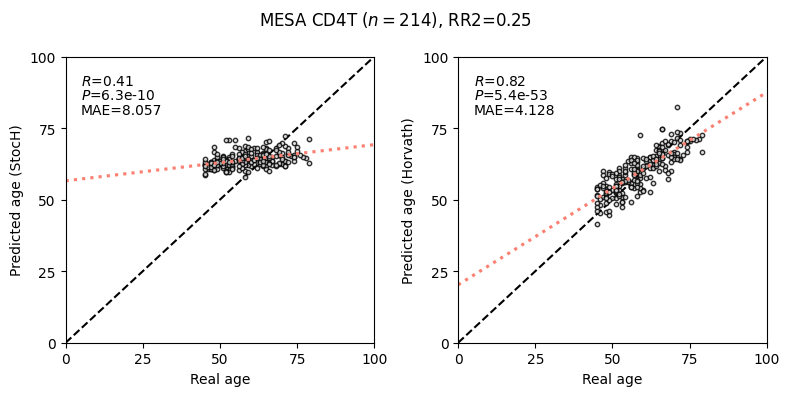

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

for ax_i in ax:
    ax_i.plot([0, 100], [0, 100], ls="--", color=colors[-2], zorder=0)
    ax_i.set_xticks(np.arange(0, 101, 25))
    ax_i.set_yticks(np.arange(0, 101, 25))
    ax_i.set_xlim(0, 100)
    ax_i.set_ylim(0, 100)


sns.regplot(x=y, y=y_pred,
            truncate=False, ci=None,
            line_kws=line_kws,
            scatter_kws=scatter_kws,
            ax=ax[0]
            )
ax[0].set_ylabel('Predicted age (StocH)')
ax[0].set_xlabel('Real age')
ax[0].text(x= 0.05, y=0.8, s=f'MAE={mae:.3f}', transform=ax[0].transAxes)
ax[0].text(x= 0.05, y=0.9, s=f'$R$={r:.2f}', transform=ax[0].transAxes)
ax[0].text(x= 0.05, y=0.85, s=f'$P$={p:.1e}', transform=ax[0].transAxes)

sns.regplot(x=y, y=y_pred_h,
            truncate=False, ci=None,
            line_kws=line_kws,
            scatter_kws=scatter_kws,
            ax=ax[1]
            )
ax[1].set_ylabel('Predicted age (Horvath)')
ax[1].set_xlabel('Real age')
ax[1].text(x= 0.05, y=0.8, s=f'MAE={mae_h:.3f}', transform=ax[1].transAxes)
ax[1].text(x= 0.05, y=0.9, s=f'$R$={r_h:.2f}', transform=ax[1].transAxes)
ax[1].text(x= 0.05, y=0.85, s=f'$P$={p_h:.1e}', transform=ax[1].transAxes)


plt.suptitle(f'MESA CD4T ($n=214$), RR2={rr2_t:.2f}')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_FOLDER, '8_predicting_age_mesa_t.svg'), dpi=300, bbox_inches='tight')

Visualization of the RR2.

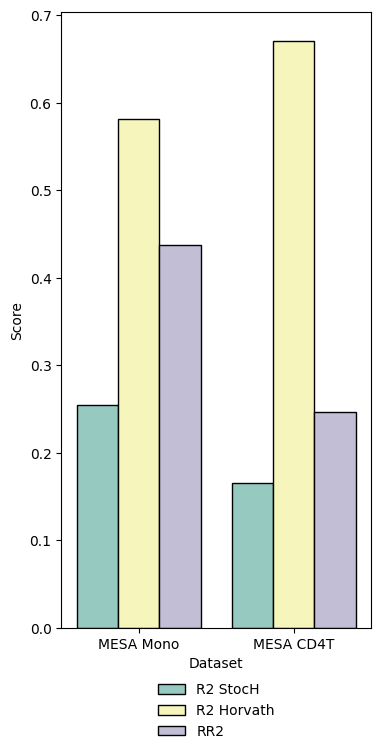

In [42]:
r_metrics = pd.DataFrame(
    [
        [r**2, r_h**2, r**2 / r_h**2, 
         mesa_mono_r[0]**2, mesa_mono_r_h[0]**2, rr2],
        ['MESA CD4T', 'MESA CD4T', 'MESA CD4T', 
         'MESA Mono', 'MESA Mono', 'MESA Mono'],
        ['R2 StocH', 'R2 Horvath', 'RR2', 
         'R2 StocH', 'R2 Horvath', 'RR2']
    ]
                           ).T
r_metrics.columns = ['Score', 'Dataset', 'Metrics']

fig, ax = plt.subplots(figsize=(4,8))
sns.barplot(r_metrics, x='Dataset', y='Score',
            order=['MESA Mono', 'MESA CD4T'],
            hue='Metrics', palette='Set3', 
            edgecolor=colors[-2], ax=ax)

plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5,-0.2))
plt.savefig(os.path.join(FIGURES_FOLDER, '9_r2_scores.svg'), 
             dpi=300, bbox_inches='tight')

# Questions

1. Can resulted simulated DNAm exceed 1? There is no restricting conditions.
2. Which datasets authors used to build clocks? Did they used any validation data?
3. There is no information about $R^2$ definition in paper. Did authors use determination scores or just squared Pearson correlation? The $R^2$ for Stoc-clocks can be negative (I have an evidence).
4. Could such a difference be explained by change in parameters?


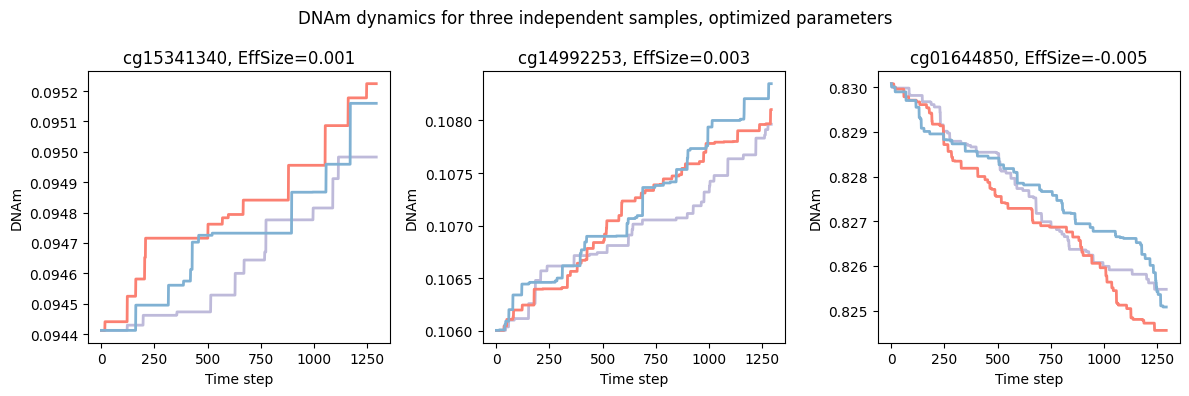

In [38]:
n_steps = 37 * 35
dnams = [[] for _ in range(3)]
for i in range(3):
    # first step depends on avgDNAm(young)
    dnams[i].append(beta_c_next(effsize_c=effect_sizes, gamma=gamma, beta_c=young_dnam_avg, sigma=sigma))

    # next steps depend on previous states
    for t in range(n_steps - 1):
        dnams[i].append(beta_c_next(effsize_c=effect_sizes, gamma=gamma, beta_c=dnams[i][-1], sigma=sigma))


fig, ax = plt.subplots(1, 3, figsize=(12,4))
rs = [104, 103, 8]
for i in range(3):
    r = rs[i]
    for j in range(3):
        ax[i].plot(np.arange(n_steps), np.array(dnams)[j, :, r], linewidth=2, color=colors[j])
    ax[i].set_title(f'{cpg_ids.loc[r]}, EffSize={round(effect_sizes.iloc[r], 3)}')
    ax[i].set_xlabel('Time step')
    ax[i].set_ylabel('DNAm')

plt.suptitle('DNAm dynamics for three independent samples, optimized parameters')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_FOLDER, 'q_simulation_random_chains_params.svg'), 
            dpi=300, bbox_inches='tight')


# Suggestions

1. Can we consider non-homogeneous Markov process by define time-dependent global methylation rate $\gamma$?
2. Can we use stochastic clocks as random matrix in mixed linear models?
